In [23]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from msc_project.utils import data_utils as du
from msc_project.utils import plot_utils as pu
import os
import pickle
import torch

plt.style.use('ggplot')

In [24]:
# DATA_DIR = '/scratch/msc24h18/msc_project/results/test48'
DATA_DIR = '/scratch/msc24h18/msc_project/tmp_onesided'
summary_files = du.get_summary_files(DATA_DIR)
weights_files = du.get_files(DATA_DIR, 'pkl', 'weights', 'analog')
analog_weights_files = du.get_files(DATA_DIR, 'pkl', 'analog_weights')
out_scaling_files = du.get_files(DATA_DIR, 'pkl', 'out_scaling_alpha')
summaries = [du.read_summary_file(f)[0] for f in summary_files]
weights = [pickle.load(open(f, 'rb')) for f in weights_files]
analog_weights = [pickle.load(open(f, 'rb')) for f in analog_weights_files]
out_scalings = [pickle.load(open(f, 'rb')) for f in out_scaling_files]
# first layer is split into two (256,392) layers, so combine them into one (256,784)
for w in weights:
    for w_i in w:
        t1 = w_i['0.analog_module.array.0.0'][0]
        t2 = w_i['0.analog_module.array.1.0'][0]
        t3 = torch.cat([t1, t2], dim=1)
        new_weight = (t3, None)
        w_i.pop('0.analog_module.array.0.0', None)
        w_i.pop('0.analog_module.array.1.0', None)
        w_i['0.analog_module'] = new_weight
        w_i.move_to_end('0.analog_module', last=False)


for f,w in zip(analog_weights_files, analog_weights):
    for w_i in w:
        if w_i is None:
            print(f)
            continue
        t1 = w_i[0][0]
        t2 = w_i[1][0]
        t3 = torch.cat([t1, t2], dim=1)
        new_weight = (t3, None)
        w_i.pop(0)
        w_i.pop(1)
        w_i.insert(0, new_weight)

labels = [os.path.basename(os.path.dirname(os.path.dirname(f))) for f in weights_files]
# labels = [os.path.basename(os.path.dirname(f)) for f in weights_files]
#labels = [s['test_time'] for s in summaries]
# labels = [s['device_id'] for s in summaries]
labels

['constant', 'default', 'ds_plainadam']

In [25]:
def filter_data(summaries, weights, labels, filter_cols, filter_vals, select_labels=None):
    filtered_summaries = []
    filtered_weights = []
    filtered_labels = []
    for s, w, l in zip(summaries, weights, labels):
        if all([s[col] == val for col, val in zip(filter_cols, filter_vals)]):
            if select_labels is not None and l not in select_labels:
                continue
            filtered_summaries.append(s)
            filtered_weights.append(w)
            filtered_labels.append(l)

    return filtered_summaries, filtered_weights, filtered_labels

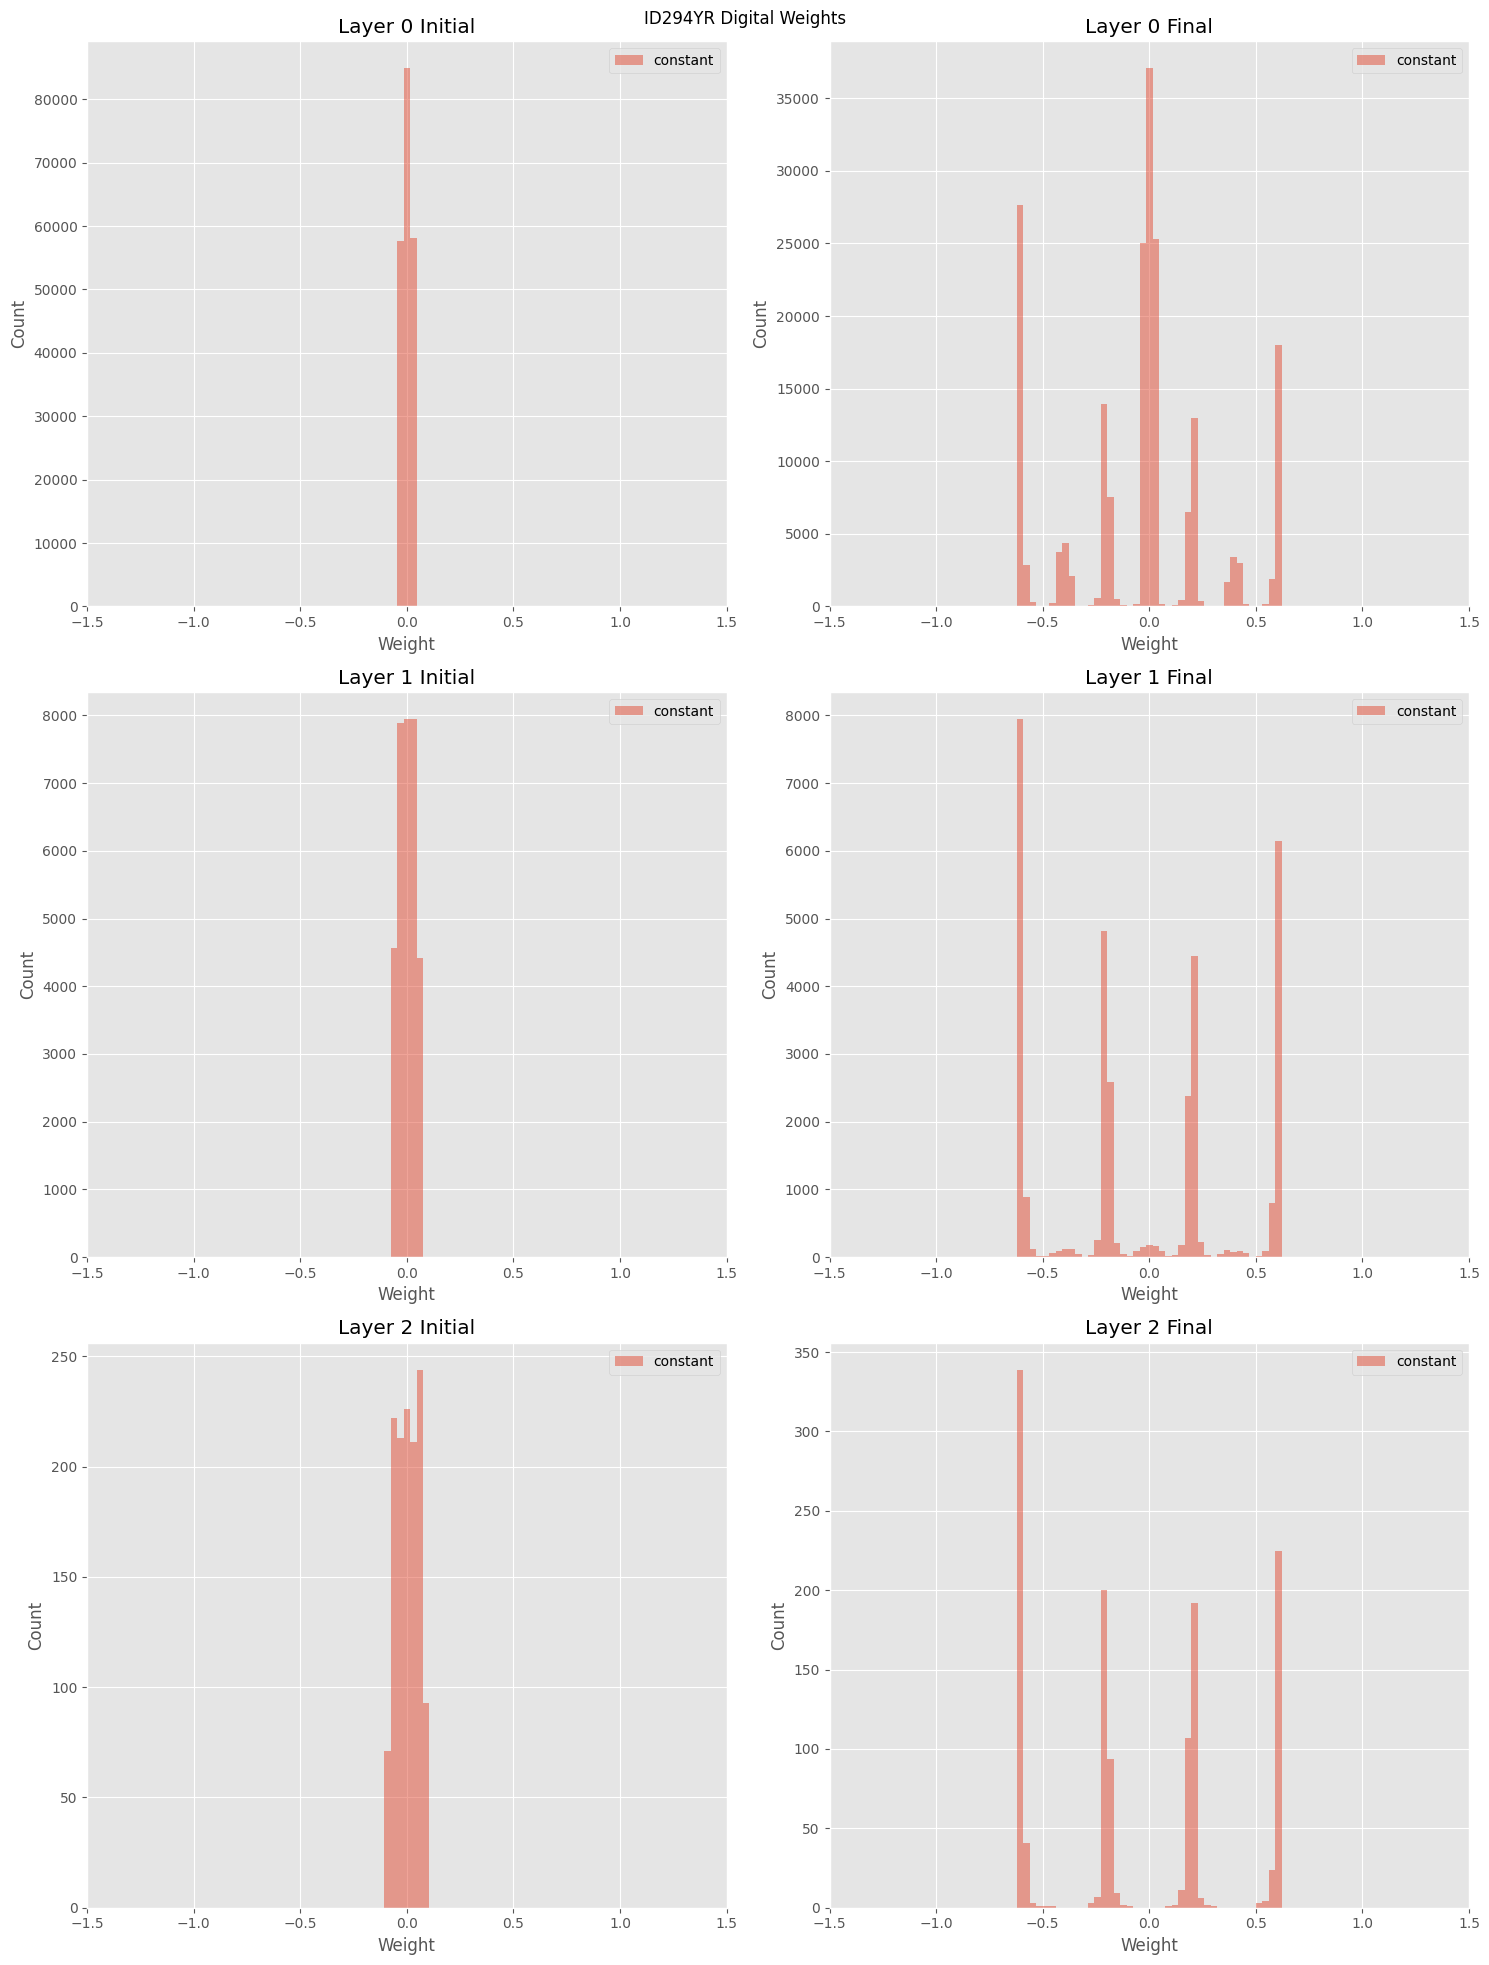

In [26]:
filter_cols = ["device_id"]
filter_vals = ["ID294YR"]
select_labels = ["constant"]
#select_labels = ["11:05:17", "11:13:50"]
# select_labels = None
filtered_summaries, filtered_weights, filtered_labels = filter_data(summaries, weights, labels, filter_cols=filter_cols, filter_vals=filter_vals, select_labels=select_labels)
pu.plot_weight_hist(filtered_weights, labels=filtered_labels, suptitle=' '.join(filter_vals) + " Digital Weights", histtype='stepfilled')
#pu.plot_weight_hist(filtered_weights, labels=["Symmetric Device", "Asymmetric Device"], suptitle="Weight Distribution Before and After Training", histtype='stepfilled')
#pu.animate_weight_hist(filtered_weights, labels=filtered_labels, suptitle='ID294YR')

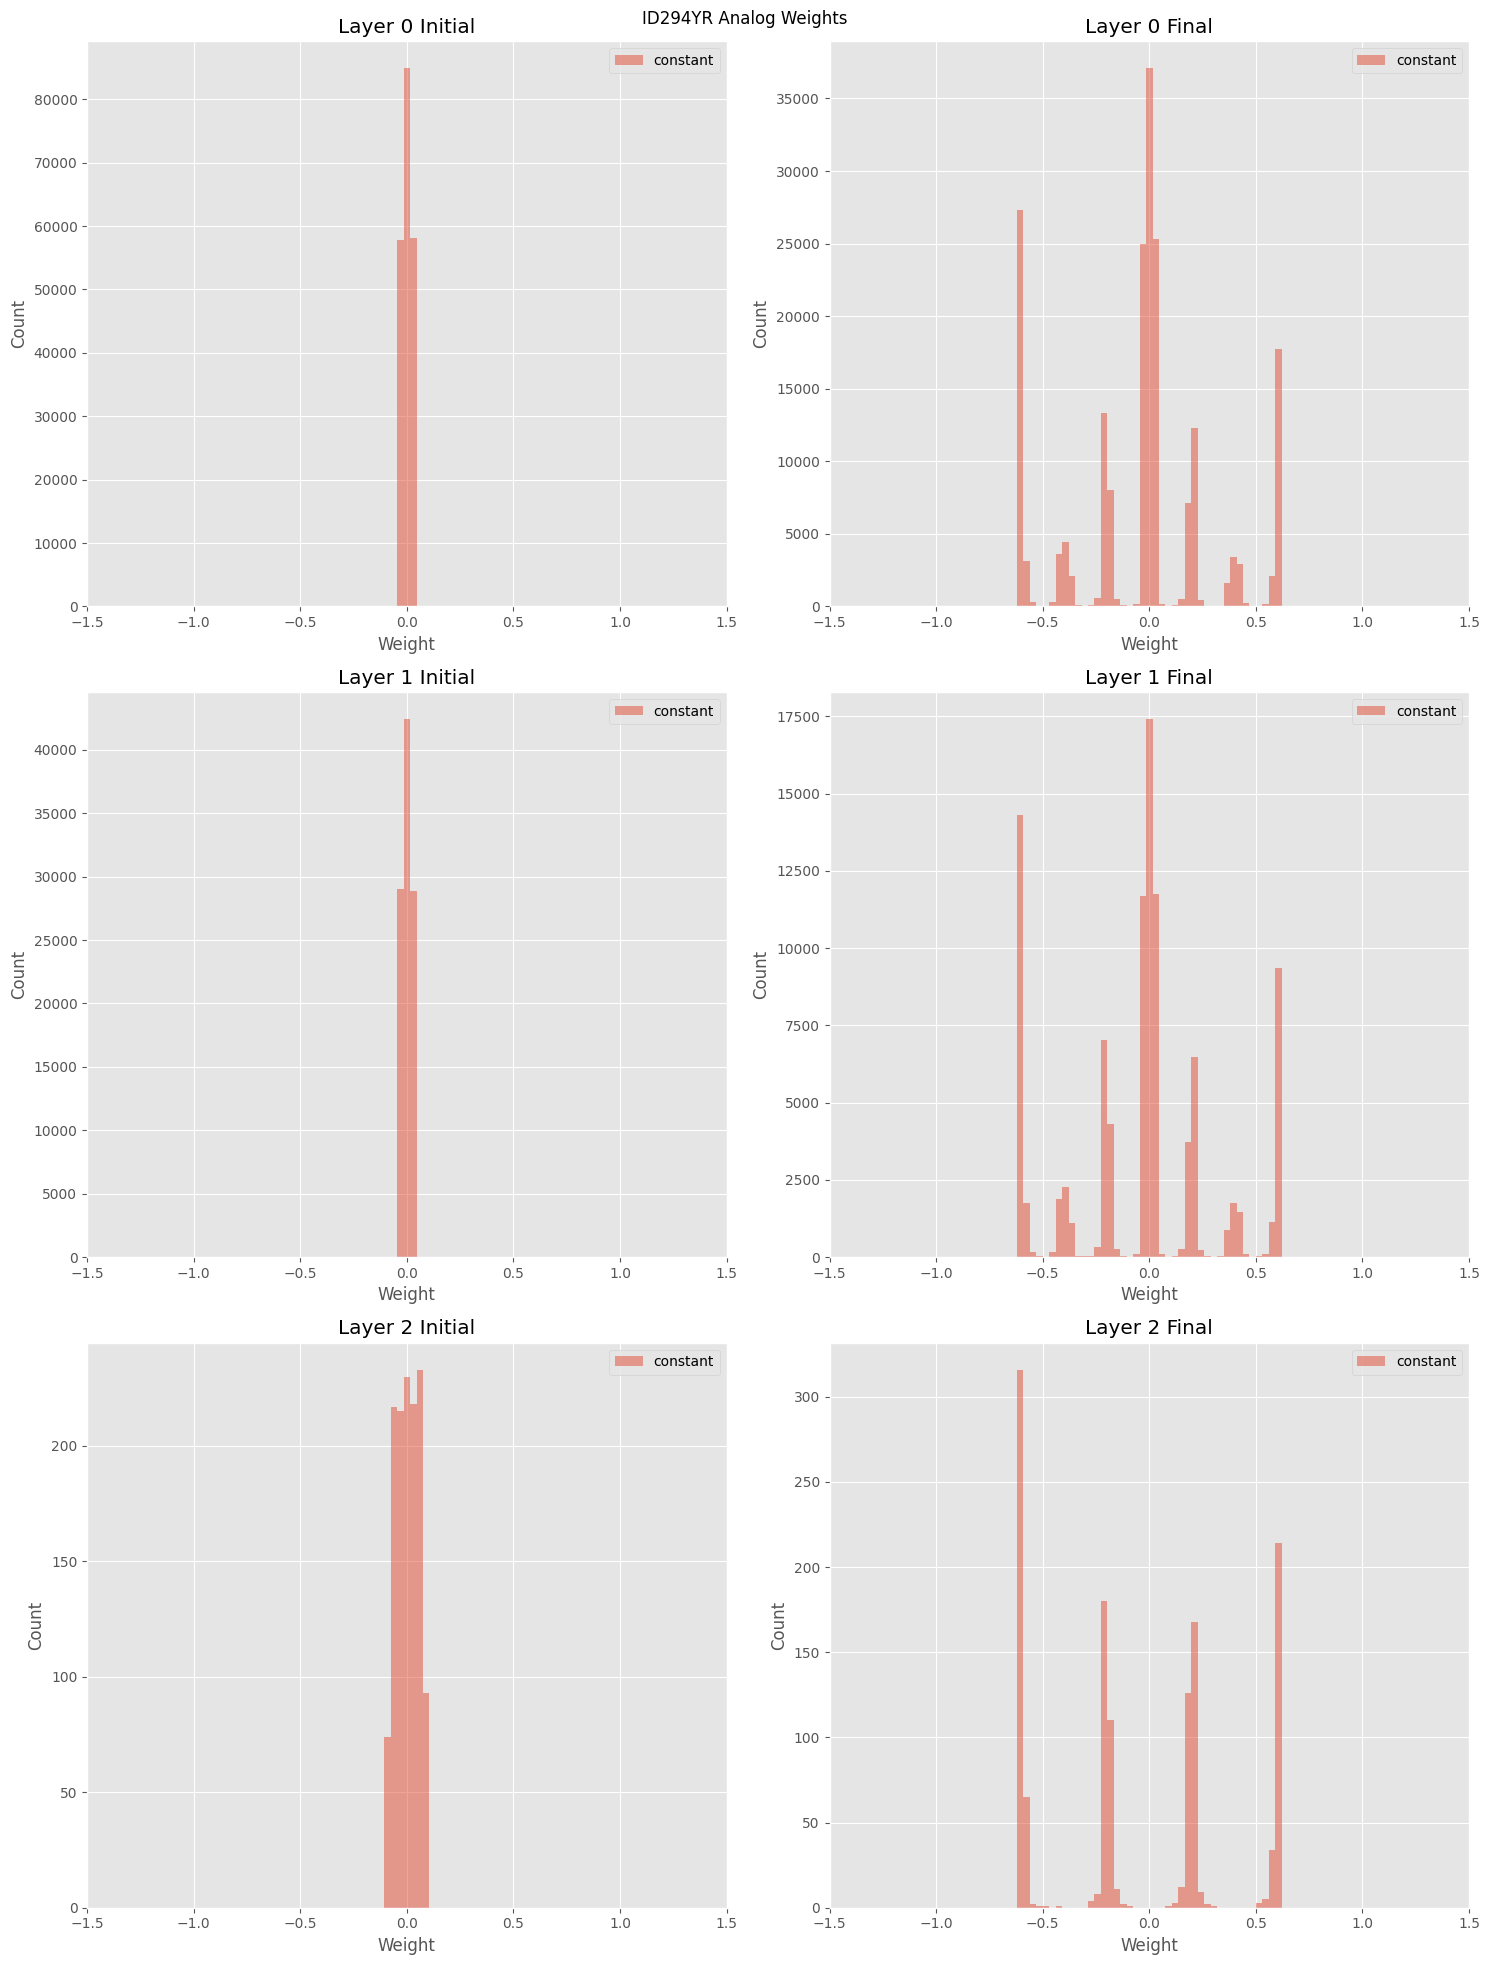

In [29]:
filtered_summaries, filtered_weights, filtered_labels = filter_data(summaries, analog_weights, labels, filter_cols=filter_cols, filter_vals=filter_vals, select_labels=select_labels)
pu.plot_weight_hist(filtered_weights, labels=filtered_labels, suptitle=' '.join(filter_vals) + ' Analog Weights')
#pu.animate_weight_hist(filtered_weights, labels=filtered_labels for s in filtered_summaries], suptitle='Analog Weights')

In [28]:
filtered_summaries, filtered_scalings, filtered_labels = filter_data(summaries, out_scalings, labels, filter_cols=filter_cols, filter_vals=filter_vals, select_labels=select_labels)
for s, l in zip(filtered_scalings, filtered_labels):
    print(l, s)

constant [None, None, None, None]
